# K-NN

## ライブラリーのインポート

In [1]:
from matplotlib.colors import ListedColormap
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn import datasets
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import StandardScaler

## データセットのインポート

In [2]:
# データセットをロード
dataset = datasets.load_wine()

# 一意なクラスラベルを出力
print('特徴量:', dataset.feature_names)
print('クラス:', np.unique(dataset.target))

columns: ['alcohol', 'malic_acid', 'ash', 'alcalinity_of_ash', 'magnesium', 'total_phenols', 'flavanoids', 'nonflavanoid_phenols', 'proanthocyanins', 'color_intensity', 'hue', 'od280/od315_of_diluted_wines', 'proline']
ラベルの種類: [0 1 2]


## データセットの確認

In [3]:
pd.set_option('display.max_columns', None)
# データセットの特徴量をDataFrameに変換
df = pd.DataFrame(dataset.data, columns=dataset.feature_names)

# 目標変数をDataFrameに追加
df['target'] = dataset.target
df.head()

,alcohol,malic_acid,ash,alcalinity_of_ash,magnesium,total_phenols,flavanoids,nonflavanoid_phenols,proanthocyanins,color_intensity,hue,od280/od315_of_diluted_wines,proline,target
0,14.23,1.71,2.43,15.6,127.0,2.80,3.06,0.28,2.29,5.64,1.04,3.92,1065.0,0
1,13.20,1.78,2.14,11.2,100.0,2.65,2.76,0.26,1.28,4.38,1.05,3.40,1050.0,0
2,13.16,2.36,2.67,18.6,101.0,2.80,3.24,0.30,2.81,5.68,1.03,3.17,1185.0,0
3,14.37,1.95,2.50,16.8,113.0,3.85,3.49,0.24,2.18,7.80,0.86,3.45,1480.0,0
4,13.24,2.59,2.87,21.0,118.0,2.80,2.69,0.39,1.82,4.32,1.04,2.93,735.0,0


In [4]:
print(f'データの形式：{df.shape}')
print(f'欠損値の数：{df.isnull().sum().sum()}')

データの形式：(178, 14)
欠損値の数：0


## 相関関係の確認

In [5]:
corr_matrix = df.corr() # 相関行列を計算

# "target"との相関が高い順に列を並び替える
sorted_columns = corr_matrix.abs().sort_values('target', ascending=False).index

# 並び替えた列順でDataFrameの相関行列を表示
sorted_corr_matrix = corr_matrix.loc[sorted_columns, sorted_columns]
print(sorted_corr_matrix)

                                target  flavanoids  \
target                        1.000000   -0.847498   
flavanoids                   -0.847498    1.000000   
od280/od315_of_diluted_wines -0.788230    0.787194   
total_phenols                -0.719163    0.864564   
proline                      -0.633717    0.494193   
hue                          -0.617369    0.543479   
alcalinity_of_ash             0.517859   -0.351370   
proanthocyanins              -0.499130    0.652692   
nonflavanoid_phenols          0.489109   -0.537900   
malic_acid                    0.437776   -0.411007   
alcohol                      -0.328222    0.236815   
color_intensity               0.265668   -0.172379   
magnesium                    -0.209179    0.195784   
ash                          -0.049643    0.115077   

                              od280/od315_of_diluted_wines  total_phenols  \
target                                           -0.788230      -0.719163   
flavanoids                         

## 説明変数と目的変数に分割

In [6]:
# 相関関係の高い2つの特徴量を抽出
select_features = ['flavanoids','od280/od315_of_diluted_wines'] #特徴量を選択
X =  df.loc[:, select_features].values
# クラスラベルを取得
y = df.loc[:, 'target'].values

## 訓練データ、テストデータに分割

In [7]:
# 全体の30%をテストデータととする
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=0, stratify=y)

In [8]:
# 各データセットのラベルの比率
print('入力データセットのyラベルの比率:', np.bincount(y))
print('訓練サブセットのyラベルの比率:', np.bincount(y_train))
print('テストサブセットのyラベルの比率:', np.bincount(y_test))

入力データセットのyラベルの比率: [59 71 48]
訓練サブセットのyラベルの比率: [41 50 33]
テストサブセットのyラベルの比率: [18 21 15]


## 特徴量のスケーリング

In [9]:
sc = StandardScaler()
# 訓練データの平均と標準偏差を計算
sc.fit(X_train)
# 平均と標準偏差を用いて標準化
X_train_std = sc.transform(X_train)
X_test_std = sc.transform(X_test)

## 最適なkの選択

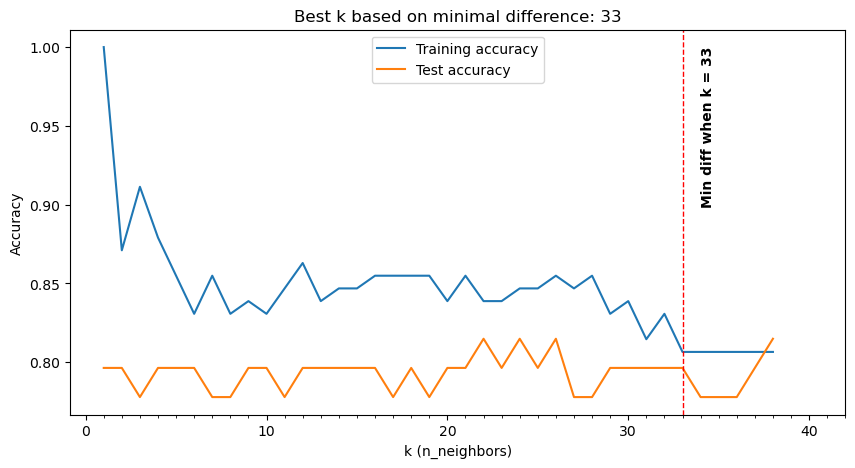

In [10]:
training_accuracy = []
test_accuracy = []

# k(n_neighbors)に対する正解率の差を最小化
min_diff = float('inf')
best_k = 0

for neighbors in range(1, 101):
    classifier = KNeighborsClassifier(n_neighbors=neighbors, metric='minkowski', p=2)
    classifier.fit(X_train_std, y_train)
    
    train_acc = classifier.score(X_train_std, y_train)
    test_acc = classifier.score(X_test_std, y_test)
    
    training_accuracy.append(train_acc)
    test_accuracy.append(test_acc)
    
    diff = abs(train_acc - test_acc)
    
    # テストデータの正解率が訓練データの正解率より高くなった場合、ループを終了
    if test_acc > train_acc:
        break
    
    # 最小差を更新
    if diff < min_diff:
        min_diff = diff
        best_k = neighbors
        
plt.figure(figsize=(10, 5))
plt.plot(range(1, len(training_accuracy) + 1), training_accuracy, label='Training accuracy')
plt.plot(range(1, len(test_accuracy) + 1), test_accuracy, label='Test accuracy')
plt.axvline(x=best_k, color='r', linestyle='--', linewidth=1)
plt.text(best_k + 1, 0.9, f'Min diff when k = {best_k}', rotation=90, fontweight='bold')
plt.xlabel('k (n_neighbors)')
plt.ylabel('Accuracy')
plt.xticks(np.arange(0, neighbors+5, step=10))
plt.xticks(np.arange(0, neighbors+5, step=1), minor=True)
plt.legend()
plt.title(f"Best k based on minimal difference: {best_k}")
plt.show()    

## 訓練データによるモデルの学習

In [19]:
# K-NNのインスタンスを作成
classifier = KNeighborsClassifier(n_neighbors = 33, metric = 'minkowski', p = 2)
# 訓練データをモデルに適合させる
classifier.fit(X_train_std, y_train)

KNeighborsClassifier(n_neighbors=33)

## 新しいデータポイントでの予測

In [20]:
# 新しいデータポイントで予測
new_data = [[4, 2]]
pred_label = classifier.predict(sc.transform(new_data))[0]
print(f'予測したクラス:{pred_label}({dataset.target_names[pred_label]})')

予測したクラス:0(class_0)


## テストデータで予測

In [21]:
# テストデータで予測を実施
y_pred = classifier.predict(X_test_std)

## モデルの性能評価

In [22]:
# 正分類のデータ点の個数を表示
print(f'正分類のデータ点: {(y_test == y_pred).sum()}個/{len(y_test)}個' )

# 分類の正解率を表示
print(f'Accuracy(Test): {accuracy_score(y_test, y_pred):.3f}')


正分類のデータ点: 43個/54個
Accuracy(Test): 0.796


## 性能評価の可視化

In [23]:
# 訓練データとテストデータの最小値と最大値を計算
def calculate_bounds(X1, X2):
    X1_min, X1_max = X1.min() - (X1.max()-X1.min())/20, X1.max() + (X1.max()-X1.min())/20
    X2_min, X2_max = X2.min() - (X2.max()-X2.min())/20, X2.max() + (X2.max()-X2.min())/20
    return X1_min, X1_max, X2_min, X2_max

In [24]:
def plot_data(ax, X_set, y_set, X1, X2, Z, colors, kind, classifier):
    cmap = ListedColormap(colors[:len(np.unique(y_set))])
    ax.contourf(X1, X2, Z, alpha=0.3, cmap=cmap)
    for idx, feature in enumerate(np.unique(y_set)):
        ax.scatter(x=X_set[y_set == feature, 0], 
                   y=X_set[y_set == feature, 1],
                   alpha=0.5, 
                   color=colors[idx],
                   marker='o', 
                   label=dataset.target_names[feature], 
                   edgecolor='black')
    ax.set_xlabel(select_features[0])
    ax.set_ylabel(select_features[1])
    ax.set_title(f'{type(classifier).__name__} ({kind})')
    ax.legend(loc='best')

In [25]:
def plot_decision_regions(X_train_std, X_test_std, y_train, y_test, classifier):
    # マーカーとカラーマップの準備
    colors = ('red', 'blue', "green")
    
    # スケーリング前の元のデータに変換
    X_train_set, y_train_set = sc.inverse_transform(X_train_std), y_train
    X_test_set, y_test_set = sc.inverse_transform(X_test_std), y_test
    
    # 訓練データとテストデータの範囲を統一
    X_combined = np.vstack((X_train_set, X_test_set))
    X1_min, X1_max, X2_min, X2_max = calculate_bounds(X_combined[:, 0], X_combined[:, 1])
    
    # グリッドポイントの生成
    X1, X2 = np.meshgrid(np.arange(X1_min, X1_max, step=(X1_max - X1_min) / 1000),
                         np.arange(X2_min, X2_max, step=(X2_max - X2_min) / 1000))
    # 各特徴を1次元配列に変換して予測を実行
    Z = classifier.predict(sc.transform(np.array([X1.ravel(), X2.ravel()]).T))
    # 予測結果を元のグリッドポイントのデータサイズに変換
    Z = Z.reshape(X1.shape)
    
    fig, ax = plt.subplots(1, 2, figsize=(8, 4))
    
    # 訓練データとテストデータのプロット
    plot_data(ax[0], X_train_set, y_train_set, X1, X2, Z, colors, "Training set", classifier)
    plot_data(ax[1], X_test_set, y_test_set, X1, X2, Z, colors, "Test set", classifier)
    
    plt.tight_layout()
    plt.show()

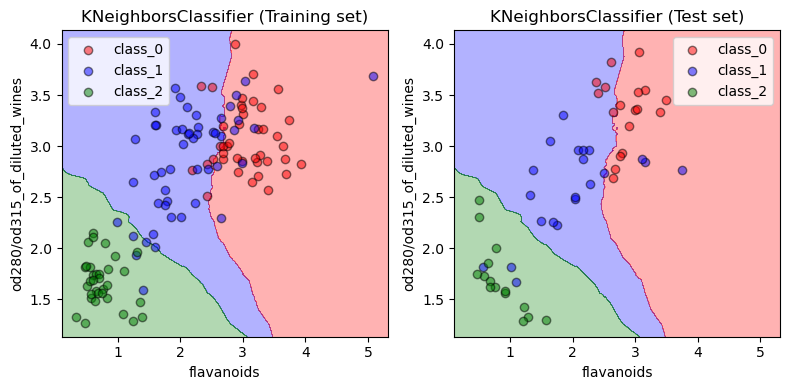

In [26]:
# 決定境界のプロット
if len(select_features) == 2:
    plot_decision_regions(X_train_std, X_test_std, y_train, y_test, classifier)
else:
    print("特徴量が2個の場合のみプロットが可能です。選択された特徴量の数:", len(select_features))
